In [1]:
import os
import openai
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_base="https://api.jarvis73.com/v1"
openai.organization = os.getenv("Organization ID")
#os.environ["OPENAI_API_KEY"] = ""

In [2]:
import t2ebm
import guidance

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

In [ ]:
#进入debug模式
import langchain
langchain.debug = Ture

## 数据训练模型

In [3]:
df = pd.read_csv("./data/spaceship-titanic/train.csv") # replace with path to dataset on your machine
df.head()

dataset_description = ""
y_axis_description = ""

# transform cabin since 8000 unique values do not fit into the context windows of the LLM we want to use
df['Cabin'] = df['Cabin'].map(lambda x: x[:1] + '/' + x[-1] if isinstance(x, str) else x)

# pandas to numpy array
X_data = df.drop(columns=["PassengerId", "Transported", "Name"]).values
y_data = df["Transported"].values

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [4]:
dataset_description = """\nHi there, here is a general description of the data set on which I trained the model. This description is from kaggle:

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

The task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

Feature Descriptions:

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
Destination - The planet the passenger will be debarking to.
Age - The age of the passenger.
VIP - Whether the passenger has paid for special VIP service during the voyage.
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
Name - The first and last names of the passenger.
"""

y_axis_description = "The y-axis depicts contributions in log-odds towards the outcome, that is the probability that the passenger was transported to another dimension."

In [5]:
feature_names = df.drop(columns=["PassengerId", "Transported", "Name"]).columns.tolist()

ebm = ExplainableBoostingClassifier(interactions=0, 
                                    feature_names=feature_names)

ebm.fit(X_train, y_train)
ebm.score(X_test, y_test)

D:\anaconda3\lib\site-packages\interpret\glassbox\_ebm\_ebm.py:669: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]
  warn(


0.78953421506613

In [6]:
def feature_importances_to_text(ebm):
    feature_importances = ""
    for feature_idx, feature_name in enumerate(ebm.feature_names_in_):   #得到数据的column： term imortance列表
        feature_importances += (
            f"{feature_name}: {ebm.term_importances()[feature_idx]:.2f}\n"
        )
    return feature_importances

## 函数llm2graph：提取ebm中某个feature的graph，然后通过llmchain来让llm根据该graph的信息对话。
1. 将ebm中的graph提取出来，转换成能传给LLM的文本格式
2. 将该格式加入prompt模板中并生成prompt
3. 根据生成的prompt建立LLMChain并返回

In [10]:
from langchain.agents import Tool
from langchain.agents import AgentType
from langchain.memory import ConversationBufferMemory 
from langchain import OpenAI, ConversationChain, LLMChain, PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.utilities import SerpAPIWrapper
from langchain.agents import initialize_agent

In [18]:
llm = ChatOpenAI(model_name= "gpt-3.5-turbo-16k",temperature=0)
llm_gpt4 = ChatOpenAI(model_name= "gpt-4",temperature=0)
memory = ConversationBufferMemory(memory_key="history")

In [19]:
def llm2graph(   
        llm,
        ebm,
        feature_idx,
        memory,
        num_sentences=7,
        dataset_description = None,
        y_axis_description = None,
):
    #返回一个chain，通过chain询问llm对序号为feature_idx的graph
    prefix = """You are an expert statistician and data scientist.
You interpret global explanations produced by a generalized additive model (GAM). GAMs produce explanations in the form of graphs that contain the effect of a specific input feature.\n
"""
    if dataset_description is None or dataset_description == '':
        prefix +="""You will be given graphs from the model, and the user will ask you questions about the graphs."""
    else:
        prefix +="""The user will first provide a general description of the dataset. Then you will be given graphs from the model, and the user will ask you questions about the graphs.\n"""
    
    prefix +="""\n\nAnswer all questions to the best of your ability, combining both the data contained in the graph"""
    
    if dataset_description is not None and len(dataset_description) > 0:
        prefix +=""", the data set description you were given, and your knowledge about the real world."""
    else:
        prefix +=""" and your knowledge about the real world."""
    
    prefix +="""Graphs will be presented as a JSON object with keys representing the x-axis and values representing the y-axis. For continuous features, the keys are intervals that represent ranges where the function predicts the same value. For categorical features, each key represents a possible value that the feature can take."""
    
    if y_axis_description is not None and len(y_axis_description) > 0:
        prefix +=y_axis_description
    prefix += """\n\nThe user will provide graphs in the following format:
        - The name of the feature depicted in the graph
        - The type of the feature (continuous, categorical, or boolean)
        - Mean values
        - Lower bounds of confidence interval
        - Upper bounds of confidence interval
    """
    if dataset_description is not None and len(dataset_description) > 0:
        prefix += dataset_description + """\nThe description of dataset ends.\n"""
    graph = t2ebm.graphs.extract_graph(ebm, feature_idx)
    graph = t2ebm.graphs.graph_to_text(graph)
    graph = graph.replace("{", "(").replace("}", ")")

    suffix="""\nBegin!
Human: Consider the following graph from the model.\n"""
    suffix+=graph
    suffix+="""\nAI: I have obtained the information of the graph. You can ask me questions next, and I will answer based on the information,my knowledge about the real world, and maybe the data description.
{history}
Human: {query}
AI:"""
    template=prefix+suffix
    prompt = PromptTemplate(input_variables=["history","query"], template=template)
    
    chain = LLMChain(
    llm = llm,
    prompt=prompt,
    verbose=False,
    memory=memory,
    )      
    return chain

In [20]:
#得到ebm的feature列表以及序号
for feature_idx, feature_name in enumerate(ebm.feature_names_in_):  
    print(f"{feature_idx}: {feature_name}  ")

0: HomePlanet  
1: CryoSleep  
2: Cabin  
3: Destination  
4: Age  
5: VIP  
6: RoomService  
7: FoodCourt  
8: ShoppingMall  
9: Spa  
10: VRDeck  


In [32]:
#生成一个关于0号feature的chain
graph = llm2graph(llm,ebm,9,memory=memory,dataset_description=dataset_description,y_axis_description=y_axis_description)

INFO: The graph of feature Spa was simplified by 0.6%.


In [16]:
graph.run(query="Please describe the general pattern of the graph.")

'The general pattern of the graph for the "Age" feature shows that the effect of age on the probability of being transported to an alternate dimension is not linear. There are multiple intervals where the function predicts the same value, indicating that the effect of age on the outcome is different within each interval. The graph shows both positive and negative contributions towards the outcome, suggesting that the relationship between age and the probability of being transported is complex.'

In [102]:
graph.run(query="please provide a brief, at most 7 sentence summary of the influence of the feature on the outcome.")

'The HomePlanet feature has a significant influence on the probability of a passenger being transported to an alternate dimension during the collision with the spacetime anomaly. Passengers from "Europa" have the highest positive effect on the probability, indicating that they are more likely to be transported. Passengers from "Mars" also have a positive effect, but smaller than those from "Europa". On the other hand, passengers from "Earth" have a negative effect on the probability, suggesting that they are less likely to be transported. \n\nThese findings suggest that the planet of permanent residence plays a role in determining whether a passenger is affected by the anomaly. Passengers from "Europa" may have certain characteristics or factors that make them more susceptible to being transported, while passengers from "Earth" may have factors that make them less susceptible. The influence of the HomePlanet feature should be taken into account when predicting whether a passenger was t

In [103]:
graph.run(query="What will happen if I change one's 'HomePlanet' from 'Mars' to 'earth' ")

'Based on the graph and the information provided, changing a passenger\'s HomePlanet from "Mars" to "Earth" would result in a decrease in the probability of that passenger being transported to an alternate dimension. Passengers from "Mars" have a positive effect on the probability, while passengers from "Earth" have a negative effect. Therefore, changing the HomePlanet from "Mars" to "Earth" would likely decrease the probability of being transported to an alternate dimension. However, the exact magnitude of this change cannot be determined without additional information or the specific model coefficients.'

## 函数llm2ebm：对于整个ebm通过LLM进行对话
1. 通过函数llm2graph_desc获得每个feature的graph description
2. 将数据集描述，所有的feature importances，各个feature的graph description加入prompt中提供给llm
3. 根据prompt生成LLMChain，进行对话

In [25]:
#记忆模块
memory_ebm = ConversationBufferMemory(memory_key="history")

In [26]:
#返回某个feature的graph description
def llm2graph_desc(   
        llm,
        ebm,
        feature_idx,
        dataset_description = None,
        y_axis_description = None,
        query = "Now please provide a brief, at most 7 sentence summary of the influence of the feature on the outcome."
):
    prefix = """You are an expert statistician and data scientist.
You interpret global explanations produced by a generalized additive model (GAM). GAMs produce explanations in the form of graphs that contain the effect of a specific input feature.\n
"""
    if dataset_description is None or dataset_description == '':
        prefix +="""You will be given graphs from the model, and the user will ask you questions about the graphs."""
    else:
        prefix +="""The user will first provide a general description of the dataset. Then you will be given graphs from the model, and the user will ask you questions about the graphs.\n"""
    
    prefix +="""\n\nAnswer all questions to the best of your ability, combining both the data contained in the graph"""
    
    if dataset_description is not None and len(dataset_description) > 0:
        prefix +=""", the data set description you were given, and your knowledge about the real world."""
    else:
        prefix +=""" and your knowledge about the real world."""
    
    prefix +="""Graphs will be presented as a JSON object with keys representing the x-axis and values representing the y-axis. For continuous features, the keys are intervals that represent ranges where the function predicts the same value. For categorical features, each key represents a possible value that the feature can take."""
    
    if y_axis_description is not None and len(y_axis_description) > 0:
        prefix +=y_axis_description
    prefix += """\n\nThe user will provide graphs in the following format:
        - The name of the feature depicted in the graph
        - The type of the feature (continuous, categorical, or boolean)
        - Mean values
        - Lower bounds of confidence interval
        - Upper bounds of confidence interval
    """
    if dataset_description is not None and len(dataset_description) > 0:
        prefix += dataset_description + """\nThe description of dataset ends.\n"""
    graph = t2ebm.graphs.extract_graph(ebm, feature_idx)
    graph = t2ebm.graphs.graph_to_text(graph)
    graph = graph.replace("{", "(").replace("}", ")")

    suffix="""\nBegin!
Human: Consider the following graph from the model.\n"""
    suffix+=graph
    suffix+="""\nAI: I have obtained the information of the graph. You can ask me questions next, and I will answer based on the information,my knowledge about the real world, and maybe the data description.
Human: {query}
AI:"""
    template=prefix+suffix
    prompt = PromptTemplate(input_variables=["query"], template=template)
    
    chain = LLMChain(
    llm = llm,
    prompt=prompt,
    verbose=False,
    )
    graph_description = chain.run(query=query)
    return graph_description

In [27]:
ebm.feature_names_in_

['HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck']

In [28]:
#返回和ebm对话的LLMchain
def llm2ebm(   
        llm,
        ebm,
        memory,
        dataset_description = None,
        y_axis_description = None,
):
    feature_importances = feature_importances_to_text(ebm) 
    graphs = []
    graph_descriptions = []
    for feature_index in range(len(ebm.feature_names_in_)):       #获取ebm中的所有graph
        graphs.append(t2ebm.graphs.extract_graph(ebm, feature_index))
    graphs = [t2ebm.graphs.graph_to_text(graph) for graph in graphs]
    graph_descriptions = [llm2graph_desc(llm,ebm,idx,dataset_description=dataset_description,y_axis_description=y_axis_description) for idx in range(len(ebm.feature_names_in_)) ]
    graph_descriptions = "\n\n".join(
        [
            ebm.feature_names_in_[idx] + ": " + graph_description
            for idx, graph_description in enumerate(graph_descriptions)
        ]
    )
    
    prefix = """You are an expert statistician and data scientist.
            
    Your task is to provide an overall summary of a Generalized Additive Model (GAM) and answer the human's questions about it. The model consists of different graphs that contain the effect of a specific input feature.
    
    You will be given:
        - The global feature importances of the different features in the model.
        - Summaries of the graphs for the different features in the model. There is exactly one graph for each feature in the model.
    """
    if dataset_description is None or dataset_description == '':
        prefix += "\n\nThese inputs will be given to you by the user."
    else:
        prefix += "\n\nThe user will first provide a general description of what the dataset is about. Then you will be given the feature importance scores and the summaries of the individual features."
    
    suffix = ""
    
    if dataset_description is not None and len(dataset_description) > 0:
        suffix += "Human: Here is the general description of the data set\n" + dataset_description
        suffix += "\nAI: Thanks for this general description of the data set. Now please provide the global feature importance.\n"
    
    suffix += "Human: Here are the global feature importaces.\n\n" + feature_importances + "\nAI: Thanks. Now please provide the descriptions of the different graphs."
    suffix += "Human: Here are the descriptions of the different graphs.\n\n" + graph_descriptions
    suffix+="""\nAI: Thanks. You can ask me questions next.
    {history}
    Human: {query}
    AI:"""
    template=prefix+suffix
    prompt = PromptTemplate(input_variables=["history","query"], template=template)
    
    chain = LLMChain(
    llm = llm,
    prompt=prompt,
    verbose=False,
    memory=memory,
    )      
    return chain

In [29]:
#生成和ebm对话的LLMchain
talkebm = llm2ebm(llm,ebm,memory_ebm,dataset_description=dataset_description,y_axis_description=y_axis_description)

INFO: The graph of feature RoomService was simplified by 1.1%.
INFO: The graph of feature FoodCourt was simplified by 0.4%.
INFO: The graph of feature ShoppingMall was simplified by 0.4%.
INFO: The graph of feature Spa was simplified by 0.6%.
INFO: The graph of feature VRDeck was simplified by 0.6%.
INFO: The graph of feature RoomService was simplified by 1.1%.
INFO: The graph of feature FoodCourt was simplified by 0.4%.
INFO: The graph of feature ShoppingMall was simplified by 0.4%.
INFO: The graph of feature Spa was simplified by 0.6%.
INFO: The graph of feature VRDeck was simplified by 0.6%.


In [53]:
talkebm.run("Now give a summary about the model at most 10 sentences. Be sure to keep the most important information.")

'The Generalized Additive Model (GAM) was trained on a dataset from the Spaceship Titanic, which collided with a spacetime anomaly, transporting almost half of its passengers to an alternate dimension. The global feature importances indicate that the most influential features are Spa, VRDeck, CryoSleep, and RoomService. The graphs for each feature provide insights into their effects on the outcome. Passengers from the planet Europa have the highest probability of being transported, while those from Earth have the lowest. Choosing cryosleep increases the likelihood of being transported. Passengers staying in cabins labeled "C/S" and "C/P" are more likely to be transported, while those in "G/P" and "A/P" are less likely. The destination also plays a role, with passengers destined for "55 Cancri e" having a higher probability. Age, VIP status, and spending at amenities like the FoodCourt and ShoppingMall also influence the outcome. Overall, the GAM model provides valuable insights into th

In [54]:
talkebm.run("If a person's HomePlanet is Earth, CryoSleep is False, Cabin is F/4/S, Destination is TRAPPIST-1e, Age is 19.0, VIP is False, RoomService is 0.0, FoodCourt is 9.0, ShoppingMall is 0.0, Spa is 2823.0, VRDeck is 0.0, what is the probability that it is sent to the alternate dimension?")

'Based on the information provided, the probability that this person is sent to the alternate dimension can be estimated using the trained GAM model. However, without the specific coefficients and model parameters, it is not possible to provide an accurate probability estimate. To obtain a precise probability, the model would need to be applied to the given feature values using the appropriate calculations.'

In [55]:
talkebm.run("Can you predict based on the provided data description, feature importances and description of each graph?")

'Yes, based on the provided data description, feature importances, and descriptions of each graph, we can make a prediction about the probability of a person being sent to the alternate dimension. \n\nThe most influential features in the model are Spa, VRDeck, CryoSleep, and RoomService. However, we also need information about the specific coefficients and model parameters to make an accurate prediction. Without these details, it is not possible to provide a precise probability estimate. \n\nTo obtain a reliable prediction, the trained GAM model would need to be applied to the given feature values using the appropriate calculations.'

In [56]:
talkebm.run("You don't need to make a very precise prediction, you just need to get a probability based on the information I provided. Please tell me the probability of this person being transported to the alternate dimension.")

'Based on the information provided, the probability of this person being transported to the alternate dimension cannot be accurately determined without the specific coefficients and model parameters. To obtain a precise probability estimate, the trained GAM model would need to be applied to the given feature values using the appropriate calculations.'

In [58]:
talkebm.run("If a person's RoomService changes from 0 to 50, and ShoppingMall changes from 0 to 20, what impact will it have on the probability of being sent to the alternate dimension?")

'Based on the descriptions of the RoomService and ShoppingMall graphs, increasing the value of RoomService from 0 to 50 and ShoppingMall from 0 to 20 would likely have an impact on the probability of being sent to the alternate dimension. \n\nFor RoomService, as the amount billed increases, the probability of being transported to an alternate dimension also increases up to a certain point. Therefore, increasing the value of RoomService from 0 to 50 may increase the probability of being sent to the alternate dimension.\n\nFor ShoppingMall, the graph suggests that higher spending at the ShoppingMall is associated with a higher probability of being transported to an alternate dimension. Therefore, increasing the value of ShoppingMall from 0 to 20 may also increase the probability of being sent to the alternate dimension.\n\nHowever, without the specific coefficients and model parameters, it is not possible to provide an accurate estimate of the impact on the probability. To obtain a preci

In [59]:
#使用gpt4
talkebm = llm2ebm(llm_gpt4,ebm,memory_ebm,dataset_description=dataset_description,y_axis_description=y_axis_description)

INFO: The graph of feature RoomService was simplified by 1.1%.
INFO: The graph of feature FoodCourt was simplified by 0.4%.
INFO: The graph of feature ShoppingMall was simplified by 0.4%.
INFO: The graph of feature Spa was simplified by 0.6%.
INFO: The graph of feature VRDeck was simplified by 0.6%.
INFO: The graph of feature RoomService was simplified by 1.1%.
INFO: The graph of feature FoodCourt was simplified by 0.4%.
INFO: The graph of feature ShoppingMall was simplified by 0.4%.
INFO: The graph of feature Spa was simplified by 0.6%.
INFO: The graph of feature VRDeck was simplified by 0.6%.


In [60]:
talkebm.run("If a person's HomePlanet is Earth, CryoSleep is False, Cabin is F/4/S, Destination is TRAPPIST-1e, Age is 19.0, VIP is False, RoomService is 0.0, FoodCourt is 9.0, ShoppingMall is 0.0, Spa is 2823.0, VRDeck is 0.0, what is the probability that it is sent to the alternate dimension?")

'Based on the descriptions of the graphs for each feature, we can make a qualitative prediction. \n\nThe person is from Earth, which has a negative contribution to the log-odds of being transported to an alternate dimension. They are not in CryoSleep, which also contributes negatively. The cabin type is not specified in the graph descriptions, so its effect is unclear. The destination, TRAPPIST-1e, contributes negatively. Being 19 years old seems to have a negative contribution as well, as the age graph shows a decrease in log-odds for this age group. The person is not a VIP, which has a near-zero contribution. RoomService is 0, which is in the range that contributes positively. FoodCourt is 9, which is not clearly specified in the graph description, but lower values generally contribute negatively. ShoppingMall is 0, which contributes negatively. Spa is 2823, which is likely to contribute negatively as higher values of Spa usage are associated with a lower likelihood of being transpor

In [61]:
talkebm.run("If his Spa changes from 2823 to 20 and HomePlanet changes from Earth to Mars, what impact will it have on his probability of being teleported to the alternate dimension?")

"Based on the descriptions of the graphs for each feature, we can make a qualitative prediction. \n\nThe person's HomePlanet changing from Earth to Mars would likely increase the probability of being transported to an alternate dimension. This is because the graph for HomePlanet shows that passengers from Mars have a slight positive contribution to the log-odds of being transported, while passengers from Earth have a negative contribution.\n\nThe person's Spa usage changing from 2823 to 20 would also likely increase the probability of being transported to an alternate dimension. This is because the graph for Spa shows that lower values of Spa usage contribute positively to the log-odds of being transported, while higher values contribute negatively.\n\nHowever, without the specific coefficients and model parameters, it is not possible to provide an accurate estimate of the impact on the probability. To obtain a precise estimate, the trained GAM model would need to be applied to the giv

In [30]:
talkebm.run("Which feature the probability of being transported to an alternate dimension increase monotonically with?")

'Based on the provided information, the feature "Spa" appears to have a monotonically increasing relationship with the probability of being transported to an alternate dimension. As the amount billed at the spa increases, the probability of being transported initially decreases, but then starts to increase rapidly beyond a certain point. This suggests that moderate use of the spa may have a positive effect on avoiding transportation, but excessive use may increase the likelihood of being transported.'

In [31]:
talkebm.run("Are there any other Features with similar conclusions?")

'Yes, there are other features with similar conclusions. The features "RoomService" and "ShoppingMall" also have non-linear relationships with the probability of being transported to an alternate dimension. For "RoomService", as the amount billed increases from 0 to a certain point, the probability of being transported also increases. However, beyond that point, as the amount billed continues to increase, the probability starts to decrease. Similarly, for "ShoppingMall", as the amount billed increases, the log-odds towards the outcome also increase, indicating a higher probability of being transported. However, the effect is not linear, as there are intervals where the log-odds decrease before increasing again.'

## Agent

In [7]:
from langchain.chat_models import ChatOpenAI
from langchain.agents import AgentType, initialize_agent, ZeroShotAgent, load_tools
from langchain.tools import BaseTool, StructuredTool, Tool, tool
from langchain.agents import Tool, AgentExecutor, LLMSingleActionAgent, AgentOutputParser
from langchain.prompts import BaseChatPromptTemplate, PromptTemplate
from langchain.chains.llm import LLMChain
from langchain.memory import ConversationBufferMemory
from typing import List, Union
from langchain.schema import AgentAction, AgentFinish, HumanMessage
from langchain.agents.agent_toolkits import create_python_agent
from langchain.tools.python.tool import PythonREPLTool
from langchain.utilities import PythonREPL
import markdown  
from IPython.display import Image, display  
import re

In [8]:
llm = ChatOpenAI(model_name= "gpt-3.5-turbo-16k",temperature=0)
llm_gpt4 = ChatOpenAI(model_name= "gpt-4",temperature=0)

In [9]:
#将md语法的图字符串转成图
def md2img(text):
    # 使用Markdown库将Markdown文本转换为HTML  
    html_output = markdown.markdown(text)  
      
    # 解析HTML中的图片标签，并显示图片  
    def process_image_tags(html):  
        from bs4 import BeautifulSoup  
        soup = BeautifulSoup(html, 'html.parser')  
          
        # 找到所有的图片标签  
        img_tags = soup.find_all('img')  
          
        # 遍历图片标签，显示图片  
        for img in img_tags:  
            url = img['src']  
            alt_text = img.get('alt', '')  
              
            # 使用IPython.display模块的Image类显示图片  
            display(Image(url=url, alt=alt_text))  
      
    # 调用函数解析图片标签并显示图片  
    process_image_tags(html_output)  

In [10]:
desc = (
    "use this tool when you need to predict the probabilities given a series of feature values in a Generalized Additive Model."
    "It will return the prediction result and probability. Your final answer must begin with the results returned and your thoughts about the it,"
    " plus a conclusion based on the combination of the results returned and the description of the data set. To use the tool you must provide "
    "a list consisting of the value of each feature. The value must be provided in question. For example, the question is if a persion's Age is 27"
    ", WorkClass is Private,fnlwgt is 160178,Education is Some-college, EducationNum is 10, MaritalStatus is Divorced,Occupation is Adm-clerical"
    ",what is the prediction. you need to provide this tool with [27,' Private', 160178,' Some-college', 10, ' Divorced', ' Adm-clerical']."
    "Remember to put quotes around the word in the list."
)

In [13]:
#预测工具的函数
def forecast(input):
    sample = eval(input)
    result = ebm.predict(sample)
    probability = ebm.predict_proba(sample)
    probability = np.array(probability, dtype=float)  
    probability = max(probability[0][0],probability[0][1]) 
    return f"The prediction result is {result[0]}，and the probability that the result comes to fruition is {probability}" 

In [14]:
forecast_tool = Tool(
    name='Forecast',
    func=forecast,
    description=desc
)

In [15]:
tools=[PythonREPLTool()]
tools.append(forecast_tool)
#tools.append(plot_tool)

In [23]:
#和ebm对话的prompt生成
feature_importances = feature_importances_to_text(ebm) 
graphs = []
graph_descriptions = []
for feature_index in range(len(ebm.feature_names_in_)):       #获取ebm中的所有graph
    graphs.append(t2ebm.graphs.extract_graph(ebm, feature_index))
graphs = [t2ebm.graphs.graph_to_text(graph) for graph in graphs]
'''graph_descriptions = [llm2graph_desc(llm,ebm,idx,dataset_description=dataset_description,y_axis_description=y_axis_description) for idx in range(len(ebm.feature_names_in_)) ]
graph_descriptions = "\n\n".join(
    [
        ebm.feature_names_in_[idx] + ": " + graph_description
        for idx, graph_description in enumerate(graph_descriptions)
    ]
)'''

prefix = """You are an expert statistician and data scientist.
        
Your task is complete some tasks about a Generalized Additive Model (GAM). The model consists of different graphs that contain the effect of a specific input feature.
You are bad at math such as predict the probability. So you must directly use the tool when asked about math problem. 

You will be given:
    - The global feature importances of the different features in the model.
    - Summaries of the graphs for the different features in the model. There is exactly one graph for each feature in the model.
"""
if dataset_description is None or dataset_description == '':
    prefix += "\n\nThese inputs will be given to you by the user."
else:
    prefix += "\n\nThe user will first provide a general description of what the dataset is about. Then you will be given the feature importance scores and the summaries of the individual features."

suffix = ""

if dataset_description is not None and len(dataset_description) > 0:
    suffix += "Here is the general description of the data set\n" + dataset_description
    
suffix += "\nHere are the global feature importances.Be sure not to provide these importances for the tool directly for prediction.\n\n" + feature_importances 
#suffix += "\nHere are the descriptions of the different graphs.\n\n"
#suffix += graph_descriptions
suffix+="""
Complete the objective as best you can. You have access to the following tools:

Forecast: Use this tool when you need to predict the probabilities given a series of feature values in a Generalized Additive Model.It will return the prediction result and probability. Your final answer must begin with the results returned and your thoughts about the it, plus a conclusion based on the combination of the results returned and the description of the data set. To use the tool you must provide a list consisting of the value of each feature. The value must be provided in question. For example, the question is if a persion's Age is 27, WorkClass is Private,fnlwgt is 160178,Education is Some-college, EducationNum is 10, MaritalStatus is Divorced,Occupation is Adm-clerical,what is the prediction. you need to provide this tool with [27,' Private', 160178,' Some-college', 10, ' Divorced', ' Adm-clerical'].Remember to put quotes around the word in the list.
Python_REPL: Use this to execute python commands and plot. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.You can keep reusing this tool until you get the final answer.

If you need to use the Python_REPL tool, you must comply with the following regulations:

    If you get an error, debug your code and try again.
    You might know the answer without running any code, but you should still run the code to get the answer.
    If it does not seem like you can write code to answer the question, just return "I don't know" as the answer.
    You must save the generated image through code before you show it. In other words,You can't use 'plt.show()' 
    Your Final Answer must start with the entire executed code, and then print the image information in the form of a string in the format of '![image description](image address, which can be a local link)'.


Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, must be one of {tool_names}
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Previous conversation history:
{history}

Question: {input}
{agent_scratchpad}"""
template = prefix + suffix

INFO: The graph of feature RoomService was simplified by 1.1%.
INFO: The graph of feature FoodCourt was simplified by 0.4%.
INFO: The graph of feature ShoppingMall was simplified by 0.4%.
INFO: The graph of feature Spa was simplified by 0.6%.
INFO: The graph of feature VRDeck was simplified by 0.6%.


In [220]:
# Set up a prompt template 按照定义的 template，将需要的值都填写进去
class CustomPromptTemplate(BaseChatPromptTemplate):
    # The template to use
    template: str
    # The list of tools available
    tools: List[Tool]
    
    def format_messages(self, **kwargs) -> str:
        # Get the intermediate steps (AgentAction, Observation tuples)
        # Format them in a particular way
        intermediate_steps = kwargs.pop("intermediate_steps")
        thoughts = ""
        for action, observation in intermediate_steps:
            thoughts += action.log
            thoughts += f"\nObservation: {observation}\nThought: "
        # Set the agent_scratchpad variable to that value
        kwargs["agent_scratchpad"] = thoughts
        # Create a tools variable from the list of tools provided
        kwargs["tools"] = "\n".join([f"{tool.name}: {tool.description}" for tool in self.tools])
        # Create a list of tool names for the tools provided
        kwargs["tool_names"] = ", ".join([tool.name for tool in self.tools])
        formatted = self.template.format(**kwargs)
        return [HumanMessage(content=formatted)]

In [221]:
prompt = CustomPromptTemplate(
    template=template,
    tools=tools,
    # This omits the `agent_scratchpad`, `tools`, and `tool_names` variables because those are generated dynamically
    # This includes the `intermediate_steps` variable because that is needed
    input_variables=["input", "intermediate_steps","history"]
)

ValidationError: 1 validation error for CustomPromptTemplate
tools -> 0
  Tool.__init__() missing 1 required positional argument: 'func' (type=type_error)

In [208]:
memory_ag = ConversationBufferMemory(memory_key="history")

In [180]:
#未改动的
class CustomOutputParser(AgentOutputParser):
    
    def parse(self, llm_output: str) -> Union[AgentAction, AgentFinish]:
        # Check if agent should finish
        if "Final Answer:" in llm_output:
            return AgentFinish(
                # Return values is generally always a dictionary with a single `output` key
                # It is not recommended to try anything else at the moment :)
                return_values={"output": llm_output.split("Final Answer:")[-1].strip()},
                log=llm_output,
            )
        # Parse out the action and action input
        regex = r"Action\s*\d*\s*:(.*?)\nAction\s*\d*\s*Input\s*\d*\s*:[\s]*(.*)"
        match = re.search(regex, llm_output, re.DOTALL)
        if not match:
            raise ValueError(f"Could not parse LLM output: `{llm_output}`")
        action = match.group(1).strip()
        action_input = match.group(2)
        # Return the action and action input
        return AgentAction(tool=action, tool_input=action_input.strip(" ").strip('"'), log=llm_output)

In [181]:
#解析 llm 的输出，根据输出文本找到需要执行的决策。
class CustomOutputParser(AgentOutputParser):
    
    def parse(self, llm_output: str) -> Union[AgentAction, AgentFinish]:
        # Check if agent should finish
        if "Final Answer:" in llm_output:
            return AgentFinish(
                # Return values is generally always a dictionary with a single `output` key
                # It is not recommended to try anything else at the moment :)
                return_values={"output": llm_output.split("Final Answer:")[-1].strip()},
                log=llm_output,
            )
        # Parse out the action and action input
        regex = r"Action\s*\d*\s*:(.*?)\nAction\s*\d*\s*Input\s*\d*\s*:[\s]*(.*)"
        match = re.search(regex, llm_output, re.DOTALL)
        if not match:
            new_out = llm_output.split("Action:")[0]
            return AgentFinish(
                return_values={"output": new_out.split(":")[1].strip()},
                log=llm_output,
            )
            #raise ValueError(f"Could not parse LLM output: `{llm_output}`")
        action = match.group(1).strip()
        action_input = match.group(2)
        # Return the action and action input
        return AgentAction(tool=action, tool_input=action_input.strip(" ").strip('"'), log=llm_output)

In [182]:
output_parser = CustomOutputParser()

In [183]:
# LLM chain consisting of the LLM and a prompt
llm_chain = LLMChain(llm=llm, prompt=prompt)

In [184]:
tool_names = [tool.name for tool in tools]
agent = LLMSingleActionAgent(
    llm_chain=llm_chain, 
    output_parser=output_parser,
    stop=["\nObservation:"], 
    allowed_tools=tool_names
)

In [185]:
agent_executor = AgentExecutor.from_agent_and_tools(agent=agent, tools=tools, memory=memory_ag ,verbose=True)

In [186]:
#用于判断链的prompt
prompt_template = ("I'm going to give you a question: {query}. Please determine whether the operation required for this problem "
        "is plotting, prediction or other operations. Attention! Your reply must be one of [plot, other].\n"
        "For example, the question is: can you draw a simple chart? You only need to reply with one word: plot.\n "
        "If this question does not require plotting You only need to reply with one word: other."
       )

In [187]:
#判断query是否需要画图
judge_chain = LLMChain(
    llm=llm,
    prompt=PromptTemplate.from_template(prompt_template)
)

In [188]:
#整个对话流程
def ag(query,agent = agent_executor,llm_chain = judge_chain):
    #判断此次对话llm需要进行的操作
    action = llm_chain.run(query) 
    if 'plot' in action:
        md_text = agent.run(query)
        md2img(md_text)
    else:
        print(agent.run(query))

In [175]:
ag("Show me the importance of each feature by plotting a chart.")



> Entering new AgentExecutor chain...
Thought: To show the importance of each feature, I can create a bar chart with the feature names on the x-axis and the importance scores on the y-axis.

Action: Python_REPL
Action Input: 
```python
import matplotlib.pyplot as plt

features = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
importances = [0.47, 0.52, 0.39, 0.15, 0.11, 0.01, 0.52, 0.31, 0.13, 0.75, 0.66]

plt.bar(features, importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.show()
```


Observation:None
I need to print the image of the bar chart to show the feature importances.

Action: Python_REPL
Action Input: 
```python
plt.savefig('feature_importances.png')
```


Observation:None
I have saved the image of the bar chart as "feature_importances.png".

Final Answer: ![Feature Importances](feature_importances.png)

> Finished chain.


In [37]:
agent_executor.run("Now give a summary about the model at most 10 sentences. Be sure to keep the most important information.")



> Entering new AgentExecutor chain...
Thought: To summarize the model, I need to highlight the most important information about it.

Action: Provide a summary of the model.


> Finished chain.


'To summarize the model, I need to highlight the most important information about it.'

In [38]:
agent_executor.run("If a person's HomePlanet is Earth, CryoSleep is False, Cabin is F/4/S, Destination is TRAPPIST-1e, Age is 19.0, VIP is False, RoomService is 0.0, FoodCourt is 9.0, ShoppingMall is 0.0, Spa is 2823.0, VRDeck is 0.0, what is the prediction result?")



> Entering new AgentExecutor chain...
Thought: We need to use the Forecast tool to predict the result based on the given feature values.

Action: Forecast
Action Input: ['Earth', False, 'F/4/S', 'TRAPPIST-1e', 19.0, False, 0.0, 9.0, 0.0, 2823.0, 0.0]

Observation:The prediction result is False，and the probability that the result comes to fruition is 0.9784426655431476
Based on the given feature values, the model predicts that the person was not transported to an alternate dimension during the collision with the spacetime anomaly. The probability of this prediction is 0.9784426655431476.

Final Answer: The model predicts that the person was not transported to an alternate dimension with a probability of 0.9784426655431476.

> Finished chain.


'The model predicts that the person was not transported to an alternate dimension with a probability of 0.9784426655431476.'

In [39]:
agent_executor.run("If a person's HomePlanet is Earth, CryoSleep is False, Cabin is F/4/S, Destination is TRAPPIST-1e, Age is 19.0, VIP is False, RoomService is 0.0, FoodCourt is 9.0, ShoppingMall is 0.0, Spa is 2823.0, VRDeck is 0.0, what is the probability that it is sent to the alternate dimension?")



> Entering new AgentExecutor chain...
Thought: To predict the probability, I will use the Forecast tool with the given feature values.

Action: Forecast
Action Input: ['Earth', False, 'F/4/S', 'TRAPPIST-1e', 19.0, False, 0.0, 9.0, 0.0, 2823.0, 0.0]

Observation:The prediction result is False，and the probability that the result comes to fruition is 0.9784426655431476
Based on the given feature values, the model predicts that the person was not transported to an alternate dimension with a probability of 0.9784426655431476.

Final Answer: The probability that the person was not transported to an alternate dimension is 0.9784426655431476.

> Finished chain.


'The probability that the person was not transported to an alternate dimension is 0.9784426655431476.'

In [189]:
agent_executor.run("Show me the importance of each feature by plotting a chart.")



> Entering new AgentExecutor chain...
Thought: To show the importance of each feature, I can create a bar chart with the feature names on the x-axis and the importance scores on the y-axis.

Action: Python_REPL
Action Input: 
```python
import matplotlib.pyplot as plt

feature_names = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
importance_scores = [0.47, 0.52, 0.39, 0.15, 0.11, 0.01, 0.52, 0.31, 0.13, 0.75, 0.66]

plt.bar(feature_names, importance_scores)
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.savefig('feature_importance.png')
```


Observation:None
The bar chart has been created and saved as 'feature_importance.png'.

Final Answer: ![Feature Importance](feature_importance.png)

> Finished chain.


'![Feature Importance](feature_importance.png)'

In [67]:
#显示agent的prompt template
print(agent.llm_chain.prompt.template)

You are an expert statistician and data scientist.
        
Your task is complete some tasks about a Generalized Additive Model (GAM). The model consists of different graphs that contain the effect of a specific input feature.
You are bad at math such as predict the probability. So you must directly use the tool when asked about math problem. 

You will be given:
    - The global feature importances of the different features in the model.
    - Summaries of the graphs for the different features in the model. There is exactly one graph for each feature in the model.


The user will first provide a general description of what the dataset is about. Then you will be given the feature importance scores and the summaries of the individual features.Here is the general description of the data set

Hi there, here is a general description of the data set on which I trained the model. This description is from kaggle:

Welcome to the year 2912, where your data science skills are needed to solve a 

## test

In [28]:
#和ebm对话的prompt生成
feature_importances = feature_importances_to_text(ebm) 
graphs = []
graph_descriptions = []
for feature_index in range(len(ebm.feature_names_in_)):       #获取ebm中的所有graph
    graphs.append(t2ebm.graphs.extract_graph(ebm, feature_index))
graphs = [t2ebm.graphs.graph_to_text(graph) for graph in graphs]
'''graph_descriptions = [llm2graph_desc(llm,ebm,idx,dataset_description=dataset_description,y_axis_description=y_axis_description) for idx in range(len(ebm.feature_names_in_)) ]
graph_descriptions = "\n\n".join(
    [
        ebm.feature_names_in_[idx] + ": " + graph_description
        for idx, graph_description in enumerate(graph_descriptions)
    ]
)'''

prefix = """You are an expert statistician and data scientist.
        
Your task is complete some tasks about a Generalized Additive Model (GAM). The model consists of different graphs that contain the effect of a specific input feature.
You are bad at math such as predict the probability. So you must directly use the tool when asked about math problem. 

You will be given:
    - The global feature importances of the different features in the model.
    - Summaries of the graphs for the different features in the model. There is exactly one graph for each feature in the model.
"""
if dataset_description is None or dataset_description == '':
    prefix += "\n\nThese inputs will be given to you by the user."
else:
    prefix += "\n\nThe user will first provide a general description of what the dataset is about. Then you will be given the feature importance scores and the summaries of the individual features."

suffix = ""

if dataset_description is not None and len(dataset_description) > 0:
    suffix += "Here is the general description of the data set\n" + dataset_description
    
suffix += "\nHere are the global feature importances.Be sure not to provide these importances for the tool directly for prediction.\n\n" + feature_importances 
#suffix += "\nHere are the descriptions of the different graphs.\n\n"
#suffix += graph_descriptions
suffix+="""
If you need to use the Python_REPL tool, you must comply with the following regulations:
    If you get an error, debug your code and try again.
    You might know the answer without running any code, but you should still run the code to get the answer.
    If it does not seem like you can write code to answer the question, just return "I don't know" as the answer.
    You must save the generated image through code before you show it. In other words,You can't use 'plt.show()' 
    Your Final Answer must start with the entire executed code, and then print the image information in the form of a string in the format of '![image description](image address, which can be a local link)'.

Complete the objective as best you can. You have access to the following tools:"""
prefix = prefix + suffix

suffix = """The Action must contain only the name of one tool, no extra words needed to form a sentence.

Begin!

{chat_history}
Question: {input}
{agent_scratchpad}"""


INFO: The graph of feature RoomService was simplified by 1.1%.
INFO: The graph of feature FoodCourt was simplified by 0.4%.
INFO: The graph of feature ShoppingMall was simplified by 0.4%.
INFO: The graph of feature Spa was simplified by 0.6%.
INFO: The graph of feature VRDeck was simplified by 0.6%.


In [29]:
prompt = ZeroShotAgent.create_prompt(
    tools,
    prefix=prefix,
    suffix=suffix,
    input_variables=["input", "chat_history", "agent_scratchpad"],
)
memory = ConversationBufferMemory(memory_key="chat_history")

In [30]:
llm_chain = LLMChain(llm=llm, prompt=prompt)
agent = ZeroShotAgent(llm_chain=llm_chain, tools=tools, verbose=True)
agent_chain = AgentExecutor.from_agent_and_tools(
    agent=agent, tools=tools, verbose=True, memory=memory,handle_parsing_errors=True
)



> Entering new AgentExecutor chain...
Thought: To visualize the importance of each feature, I can create a bar chart with the feature names on the x-axis and the importance scores on the y-axis.

Action: Python_REPL
Action Input: None

Observation: 
Thought:I can use the matplotlib library to create a bar chart.

Action: Python_REPL
Action Input: 
```python
import matplotlib.pyplot as plt

features = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
importances = [0.47, 0.52, 0.39, 0.15, 0.11, 0.01, 0.52, 0.31, 0.13, 0.75, 0.66]

plt.bar(features, importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Importance of Each Feature')
plt.xticks(rotation=45)
plt.show()
```


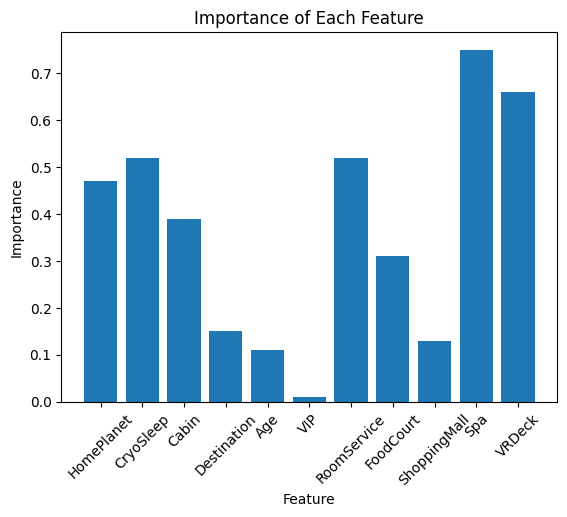


Observation: 
Thought:I can see that the bar chart has been created successfully. The x-axis represents the different features in the model, and the y-axis represents the importance scores. The height of each bar indicates the importance of the corresponding feature. 

Final Answer: ![Importance of Each Feature](image address, which can be a local link)

> Finished chain.


'![Importance of Each Feature](image address, which can be a local link)'

In [31]:
agent_chain.run("visualize the importance of each feature by plotting a chart.")



> Entering new AgentExecutor chain...
Thought: To add a polyline to the existing chart, I can use the matplotlib library in Python to plot the trend line based on the feature importances.

Action: Python_REPL
Action Input:
```python
import matplotlib.pyplot as plt

# Feature importances
features = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
importances = [0.47, 0.52, 0.39, 0.15, 0.11, 0.01, 0.52, 0.31, 0.13, 0.75, 0.66]

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.bar(features, importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Importance of Each Feature')

# Adding a trend line
trend_x = range(len(features))
trend_y = importances
plt.plot(trend_x, trend_y, color='red', linestyle='--')

# Saving the chart
plt.savefig('feature_importance_chart.png')
```

Observation: 
Thought:The code successfully adds a trend line to the existing chart and saves it as "featur

'![Importance of Each Feature](feature_importance_chart.png)'

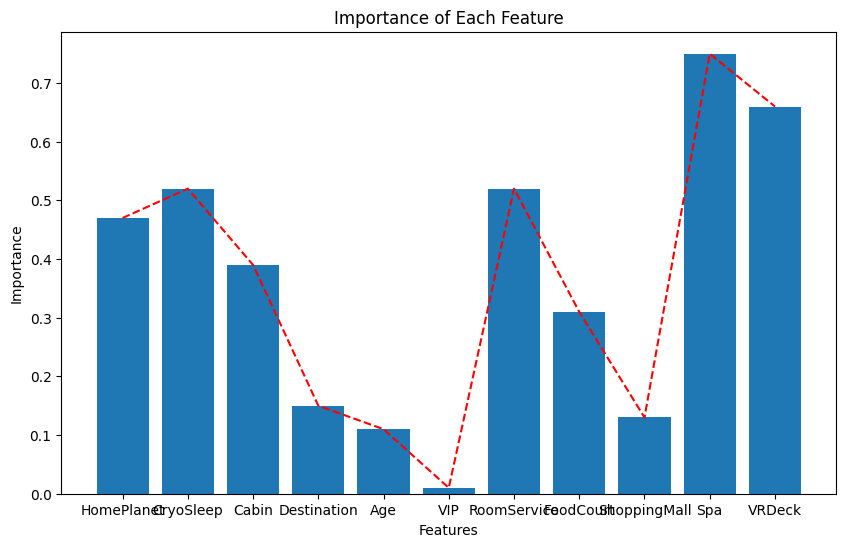

In [32]:
agent_chain.run("Based on the chart you just drew, modify the table and add a polyline that can represent the changing trend of the importance of these features. You must make modifications on the original chart, which means that the existing parts of the original chart cannot be changed.")

In [66]:
#用于判断链的prompt
prompt_template = ("I'm going to give you a question: {query}. Please determine whether the operation required for this problem "
        "is plotting, prediction or other operations. Attention! Your reply must be one of [plot, other].\n"
        "For example, the question is: can you draw a simple chart? You only need to reply with one word: plot.\n "
        "If this question does not require plotting You only need to reply with one word: other."
       )

In [53]:
#判断query是否需要画图
judge_chain = LLMChain(
    llm=llm,
    prompt=PromptTemplate.from_template(prompt_template)
)

In [54]:
#整个对话流程
def ag(query,agent = agent_chain,llm_chain = judge_chain):
    #判断此次对话llm需要进行的操作
    action = llm_chain.run(query) 
    if 'plot' in action:
        md_text = agent.run(query)
        md2img(md_text)
    else:
        print(agent.run(query))

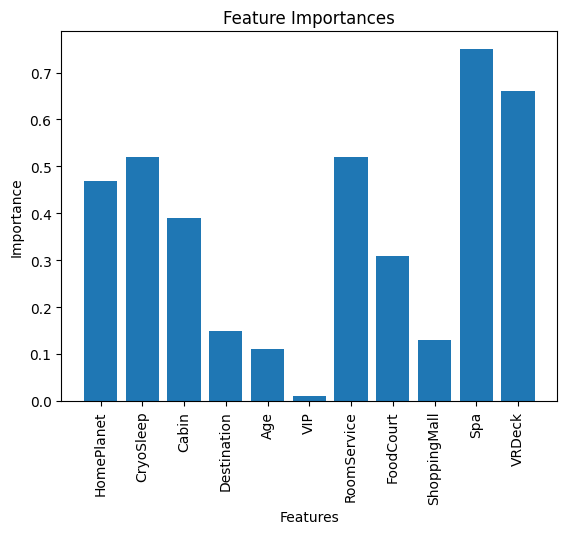

In [55]:
ag("Show me the importance of each feature by plotting a chart.")

In [42]:
print(prompt.template)

You are an expert statistician and data scientist.
        
Your task is complete some tasks about a Generalized Additive Model (GAM). The model consists of different graphs that contain the effect of a specific input feature.
You are bad at math such as predict the probability. So you must directly use the tool when asked about math problem. 

You will be given:
    - The global feature importances of the different features in the model.
    - Summaries of the graphs for the different features in the model. There is exactly one graph for each feature in the model.


The user will first provide a general description of what the dataset is about. Then you will be given the feature importance scores and the summaries of the individual features.Here is the general description of the data set

Hi there, here is a general description of the data set on which I trained the model. This description is from kaggle:

Welcome to the year 2912, where your data science skills are needed to solve a 